In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [254]:
red = pd.read_csv("winequality-red.csv")
white = pd.read_csv("winequality-white.csv")

def define_quality_labels(v):
  if v <= 5:
    return 'low'
  if v <= 7:
    return 'medium'
  return 'high'

red.columns = red.columns.str.replace(" ", "_")
white.columns = white.columns.str.replace(" ", "_")

In [255]:
# red['type'] = 0
# white['type'] = 1

red['quality_label'] = red['quality'].apply(define_quality_labels)
white['quality_label'] = white['quality'].apply(define_quality_labels)

white['quality_label'] = pd.Categorical(white['quality_label'], categories=['low', 'medium', 'high'])
red['quality_label'] = pd.Categorical(red['quality_label'], categories=['low', 'medium', 'high'])

# white['bound_sulfur_dioxide'] = white['total_sulfur_dioxide'] - white['free_sulfur_dioxide']
# red['bound_sulfur_dioxide'] = red['total_sulfur_dioxide'] - red['free_sulfur_dioxide']

combined = pd.concat([red, white], ignore_index=True)


dfml_red = red.copy()
dfml_white = white.copy()

# dfml_white.info()
# dfml_red.info()

# manual attempt at outlier removal 
# dfml_white = dfml_white[(dfml_white['total_sulfur_dioxide'] < 350) & (dfml_white['free_sulfur_dioxide'] < 200) & (dfml_white['residual_sugar'] < 50)]

# use interquartile range to remove outliers
# Q1 = dfml_white.quantile(0.25)
# Q3 = dfml_white.quantile(0.75)
# IQR = Q3 - Q1
# # print(IQR)
# new_df = dfml_white[~((dfml_white < (Q1 - 1.5 * IQR)) |(dfml_white > (Q3 + 1.5 * IQR))).any(axis=1)]
# new_df

dfml_white.drop(['quality', 'density'], axis=1, inplace=True)
dfml_red.drop(['quality', 'density'], axis=1, inplace=True)
dfml_white


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,pH,sulphates,alcohol,quality_label
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,3.00,0.45,8.8,medium
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,3.30,0.49,9.5,medium
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,3.26,0.44,10.1,medium
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,3.19,0.40,9.9,medium
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,3.19,0.40,9.9,medium
...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,3.27,0.50,11.2,medium
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,3.15,0.46,9.6,low
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,2.99,0.46,9.4,medium
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,3.34,0.38,12.8,medium


In [256]:
# encoding
# cat_col_encode = pd.get_dummies(dfml_white['quality_label'])
# dfml_white = pd.concat([dfml_white, cat_col_encode], axis=1)
# dfml_white.drop(columns=['free_sulfur_dioxide', 'quality_label', 'quality'], axis=1, inplace=True)
# dfml_white.head()

encoder = OrdinalEncoder()
encoder.fit(dfml_white[['quality_label']])
dfml_white[['quality_label']] = encoder.transform(dfml_white[['quality_label']])

encoder.fit(dfml_red[['quality_label']])
dfml_red[['quality_label']] = encoder.transform(dfml_red[['quality_label']])

dfml_white
# 0 = high, 1 = low, 2 = medium

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,pH,sulphates,alcohol,quality_label
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,3.00,0.45,8.8,2.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,3.30,0.49,9.5,2.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,3.26,0.44,10.1,2.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,3.19,0.40,9.9,2.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,3.19,0.40,9.9,2.0
...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,3.27,0.50,11.2,2.0
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,3.15,0.46,9.6,1.0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,2.99,0.46,9.4,2.0
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,3.34,0.38,12.8,2.0


# White Wine Logistic Regression

In [257]:
y = dfml_white['quality_label']
X = dfml_white.drop(['quality_label'], axis=1)


# kf = StratifiedKFold() # kf = KFold()
# for train_i, test_i in skf.split(X, y):
#     X_train, X_test = X.iloc[train_i], X.iloc[test_i]
#     y_train, y_test = y[train_i], y[test_i]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# X_train.groupby(['quality_label'])['quality_label'].count() #don't drop quality label in order to see this 
# dfml_white.groupby(['quality_label'])['quality_label'].count()
# 0 = high, 1 = low, 2 = medium



(3918, 10) (980, 10)
(3918,) (980,)


In [258]:
# scaler = StandardScaler()
# scaler = MinMaxScaler()
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.transform(X_test)

In [259]:
# LogisticRegression model
# LR_model = LogisticRegression(solver='liblinear', random_state=42)
LR_model = LogisticRegression(random_state=42, max_iter=10000)

# fit model
LR_model.fit(X_train_standard, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [260]:
preds = LR_model.predict(X_test_standard)

acc = accuracy_score(y_test, preds)
cm = confusion_matrix(y_test, preds)
print("accuracy: ", acc)
print("confusion_matrix: \n", cm)
print(classification_report(y_test, preds))

# slightly improved by removing free + total SO2

accuracy:  0.7071428571428572
confusion_matrix: 
 [[  0   0  35]
 [  1 158 162]
 [  0  89 535]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        35
         1.0       0.64      0.49      0.56       321
         2.0       0.73      0.86      0.79       624

    accuracy                           0.71       980
   macro avg       0.46      0.45      0.45       980
weighted avg       0.67      0.71      0.68       980



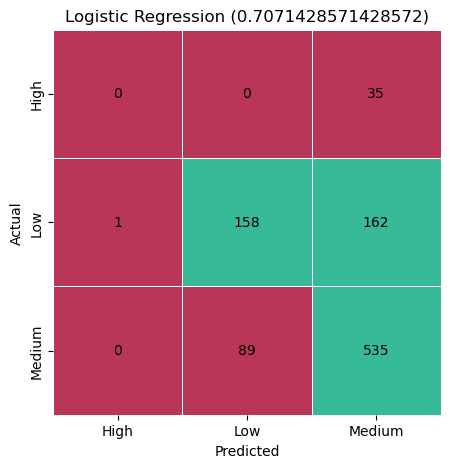

In [261]:
plt.figure(figsize=(5,5))

cm_df = pd.DataFrame(cm, index=["High","Low", "Medium"], columns=["High", "Low", "Medium"])

cmap = sns.color_palette(["#BA3658", "#36BA98", "#BA3658", "#36BA98"])
sns.heatmap(cm_df, annot=True, fmt='d', cmap=cmap, cbar=False, linewidths=.5, linecolor='white', annot_kws={"color": "black"})

plt.title('Logistic Regression (' + str(acc) + ')')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



# White Wine Random Forest

In [265]:
param_grid = { 
    'n_estimators': np.arange(10, 210, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': np.arange(2, 9),
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(estimator=RF_clf, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

KeyboardInterrupt: 

In [ ]:
# Random Forest Classifier model
RF_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# fit model
RF_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
score = RF_clf.score(X_test, y_test)

# predictions
preds = RF_clf.predict(X_test)

# accuracy
acc = accuracy_score(y_test, preds)
cm = confusion_matrix(y_test, preds)


print("accuracy score:", acc)
print("confusion_matrix: \n", cm)
print("classification report: \n", classification_report(y_test, preds))
print("score:", score)


accuracy score: 0.8295918367346938
confusion_matrix: 
 [[ 15   0  20]
 [  0 235  86]
 [  0  61 563]]
classification report: 
               precision    recall  f1-score   support

         0.0       1.00      0.43      0.60        35
         1.0       0.79      0.73      0.76       321
         2.0       0.84      0.90      0.87       624

    accuracy                           0.83       980
   macro avg       0.88      0.69      0.74       980
weighted avg       0.83      0.83      0.83       980

score: 0.8295918367346938


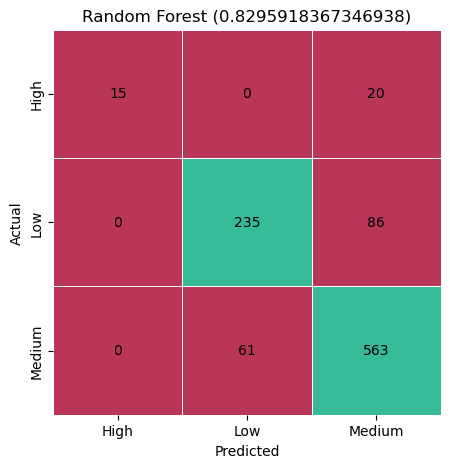

In [ ]:
from matplotlib.lines import Line2D

# plt.figure(figsize=(5,5))
fig, ax = plt.subplots(figsize=(5,5))

cm_df = pd.DataFrame(cm, index=["High","Low", "Medium"], columns=["High", "Low", "Medium"])

cmap = sns.color_palette(["#BA3658", "#36BA98", "#BA3658", "#36BA98"])
sns.heatmap(cm_df, annot=True, fmt='d', cmap=cmap, cbar=False, linewidths=.5, linecolor='white', annot_kws={"color": "black"})

plt.title('Random Forest (' + str(acc) + ')')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# my_colors = ["#BA3658", "#36BA98"]
# unavail_color = 'lightgray'
# handles = [
#   Line2D(
#     [], 
#     [], 
#     lw=10, 
#     color=color, 
#     label=label) 
#     for color, label in zip(my_colors + [unavail_color],
#     ['Incorrectly Predicted', 'Correctly Predicted'])]

# ax.legend(handles=handles, bbox_to_anchor=(0.5, -0.02), loc='upper center')

# ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()